# Thalamocortical loops for fast initial state prepration
In this version we get statistics across $N$, the ranks of $U$ and $V$, and $\beta$

## Notebook setup

### Magics

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import numpy as np
import numpy.random as npr
np.set_printoptions(linewidth=200)

from matplotlib import pyplot as plt
from matplotlib import patches
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

from time import time
import dill
import os

import tensorflow as tf
import tensorflow_probability as tfp

from my_lbfgs import build_model, do_adam, do_lbfgs, extract_Us_and_Vs

### Version check
We want Tensorflow 2.3 and Tensorflow Probability 0.11

In [3]:
print(f'tf version: {tf.__version__}')
print(f'tfp version: {tfp.__version__}')
print(f'GPUs: {[device.name for device in tf.config.list_physical_devices("GPU")] if len(tf.config.list_physical_devices("GPU")) else None}')

tf version: 2.3.0
tfp version: 0.11.0
GPUs: None


# Statistics over $N$ and the ranks of $U$ and $V$

### Model parameters

In [4]:
# network parameters
tau = 0.01  # neural time constant (s)
Ns = [100, 300, 500]  # network sizes, must be an iterable
n_fracs = [0.03, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]  # rank of U and V as fraction of N, must be an iterable
K = 5  # number of repeats per condition

# random seeds
numpy_seed = 1000

### Loss parameters

In [5]:
# penalty for solutions that don't decay
alpha = 1e5

# smoothness constraint
betas = [0.01]  # for all the stats over N and n

### Learning parameters

In [6]:
# learning
adam_epochs = 30
adam_learning_rate = 0.01
lbfgs_iters = 200
print_interval = 10
do_optimization = False
file_prefix = 'prep_opt'

In [7]:
# set numpy seed
npr.seed(numpy_seed)

## Learning
There are no batches here and the number of parameters is relatively small, so quasi-Newton optimization should be fast. However, empirically, we've found that L-BFGS is unstable at the beginning of optimization when starting from random $U$ and $V$. Thus we start with a few steps of ADAM followed by L-BFGS. 

We do the optimization of $U$ and $V$ in the shell due to high memory demands when $N=500$. We save the optimized $U$'s and $V$'s in `prep_opt_data.dill`. If `do_optimization==False`, we load previously optimized $U$'s and $V$'s. (And don't check to make sure that the parameters are correct!)

In [8]:
if do_optimization:
    outs, models = [], []
    for i, N in enumerate(Ns):
        _outs, _models = [], []
        for n, frac in enumerate(n_fracs):
            print(f'******************************************************')
            print(f'   N = {N}, frac = {frac}')
            print(f'******************************************************')
            print(os.popen(f'python train_models.py -T {tau} -N "{N}" -F "{frac}" -k {K} -r {numpy_seed + 100 * i + n} -a {alpha} -b "{betas[0]}" -A {adam_epochs} -l {adam_learning_rate} -L {lbfgs_iters} -p {print_interval} -f {file_prefix}_N_{N}_frac_{frac}.dill').read())

            with open(f'{file_prefix}_N_{N}_frac_{frac}.dill', 'rb') as f:
                out, model = dill.load(f)
            out, model = out[0], model[0]
            param, l_lbfgs, results = out
            out = dict(
                param=param,
                losses=np.stack(l_lbfgs),
                converged=results.converged,
                failed=results.failed
            )
            _outs.append(out)
            _models.append(model)
        outs.append(_outs)
        models.append(_models)
    with open(f'{file_prefix}_data.dill', 'wb') as f:
        dill.dump((outs, models), f)    

Load saved $U$'s and $V$'s

In [9]:
with open(f'{file_prefix}_data.dill', 'rb') as f:
    outs, models = dill.load(f)   

## Display results
For statistics over $N$ and the ranks of $U$ and $V$

Here, we plot:
* the learning curves
* the decay times as a functions of the ranks of $U$ and $V$ for each $N$
* the fractions $\|x(t)\|/\|x(0)\|$ as functions of the preparatory time $t$ for each $N$ and rank of $U$ \& $V$

### Display parameters

In [10]:
fracs = [0.01, 0.05]  # the fractions of the norms of the activity for which we want the decay times
t_min = 1  # min time when plotting decays (in units of tau)
t_max = 20  # max time when plotting decays (in units of tau)
loss_range = [0.3, 2]  # y-range when plotting second row of learning curves figure
do_decay_time_computation = False

### The learning curves

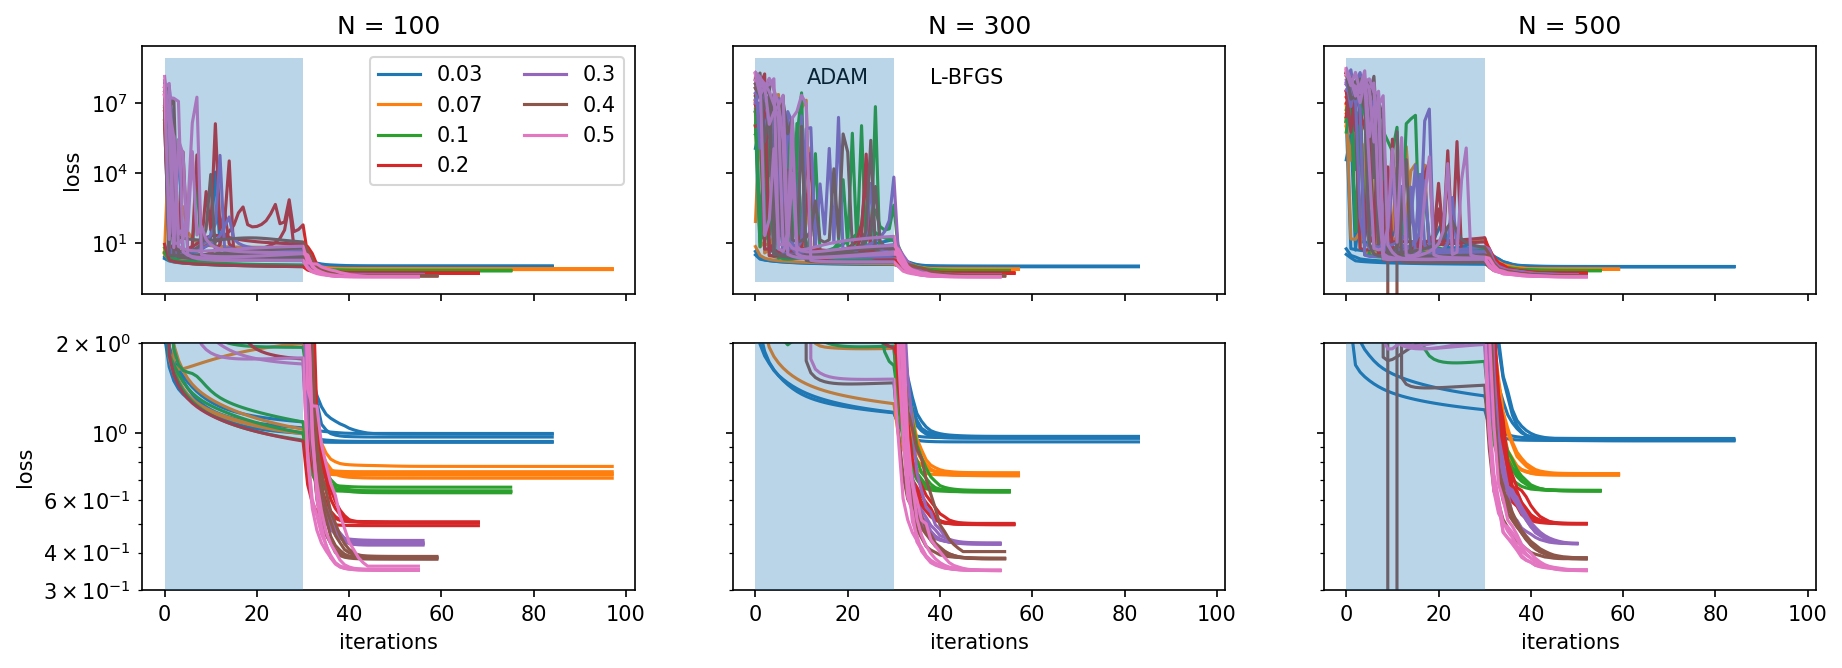

In [11]:
fig, _axes = plt.subplots(2, len(Ns), figsize=[4.8 * len(Ns), 2.4 * 2], sharex=True, sharey='row')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for a, axes in enumerate(_axes):
    for ax, _outs, N in zip(axes, outs, Ns):
        for n in range(len(n_fracs)):
            losses = _outs[n]['losses']
            ax.plot(np.arange(losses.shape[0]), losses[..., 0, 0], color=colors[n])

        ax.set_yscale('log')
        if a == 0:
            ax.set_title(f'N = {N}')
        else:
            ax.set_ylim(loss_range)
            ax.set_xlabel('iterations')
        rect = patches.Rectangle([0, .2], adam_epochs, 9e8, color=colors[0], alpha=0.3, ec=None, zorder=10)
        ax.add_patch(rect)

    axes[0].set_ylabel('loss')
_axes[0, 0].legend([_axes[0, 0].get_children()[K * n + 1] for n in range(len(n_fracs))], [f'{n}' for n in n_fracs], ncol=2)
_axes[0, 1].text(0.15, 0.85, f'ADAM', transform=_axes[0, 1].transAxes)
_axes[0, 1].text(0.4, 0.85, f'L-BFGS', transform=_axes[0, 1].transAxes)
plt.show()

### Compute decay times for each $N$ and rank of $U$ and $V$
This function returns a function $f_U(t)$ – specific to a given $U$ and $V$ – such that $f_U(t) = \|x(t)\| / \|x(0)\|$

In [12]:
def get_norm_frac_fn(param, model):
    Us, Vs = extract_Us_and_Vs(param, model)
    Js = model['J0s'] + Us @ Vs
    d, r = np.linalg.eig(Js)
    r_conj = r.conj()
    L = np.linalg.inv(np.swapaxes(r_conj, -2, -1) @ r)
    g = (d - 1) / model['tau']
    G = g[..., None] + g.conj()[..., None, :]

    def _norm_frac_fn(t):
        E = tf.math.exp(G * tf.cast(t, tf.complex128)[..., None])
        return tf.math.sqrt(tf.math.real(tf.reduce_sum((r @ (L * E)) * r_conj, axis=[-1, -2])) / N)
    return _norm_frac_fn

Find the decay times $t_d$ such that $f_U(t_d)$ equals the desired norm fractions in `fracs`

In [13]:
f = [*fracs, min(fracs) / 2]

if do_decay_time_computation:
    print(f'Locating decay times for the norm fractions {f[:-1]}')
    t_d = []
    for N, _outs, _models in zip(Ns, outs, models):
        _t_d = []
        for n, (model, out) in enumerate(zip(_models, _outs)):
            print(f'   N {N}, frac {n_fracs[n]}')
            norm_frac = get_norm_frac_fn(out['param'], model)

            _f = tf.stack([tf.ones(model['batch_shape'], dtype=tf.float64) * _f for _f in f])
            start = tf.ones([len(f), *model['batch_shape'], 1], dtype='float64') * 10 * model['tau']
            optim_results = tfp.optimizer.bfgs_minimize(
                lambda t: tfp.math.value_and_gradient(
                    lambda t: (norm_frac(t) - _f)**2,
                    t),
                initial_position=start,
                tolerance=1e-8)
            assert not np.any(optim_results.failed), f'We failed. N {N}, frac {n_fracs[n]}'
            assert np.all(optim_results.converged), f"We didn't converge. N {N}, frac {n_fracs[n]}"
            assert np.allclose(_f, norm_frac(optim_results.position))
            _t_d.append(optim_results.position)
        t_d.append(_t_d)

Compute $f_U(t)$ for a range of $t$ as specified with `t_min` and `t_max`

In [14]:
t = np.linspace(t_min, t_max, 500)

if do_decay_time_computation:
    print(f'Computing the norm fractions as a function of time')
    norms = []
    for N, _outs, _models in zip(Ns, outs, models):
        _norms = []
        for n, (model, out) in enumerate(zip(_models, _outs)):
            print(f'   N {N}, frac {n_fracs[n]}')
            norm_frac = get_norm_frac_fn(out['param'], model)
            _t = (t * tau).reshape(-1, *[1 for _ in model['batch_shape']], 1)
            _norms.append(norm_frac(_t).numpy().squeeze().T)
        norms.append(_norms)
    norms = np.stack(norms)

In [15]:
if do_decay_time_computation:
    with open(f'{file_prefix}_decay_time_data.dill', 'wb') as file:
        dill.dump((t_d, norms), file)
else:
    with open(f'{file_prefix}_decay_time_data.dill', 'rb') as file:
        t_d, norms = dill.load(file) 

### Decay time as a function of the rank of $U$ and $V$
Each line is the mean $\pm1$ standard deviation over $K$ random samples of the matrices $J_0$ and the pre-optimized $U$ \& $V$

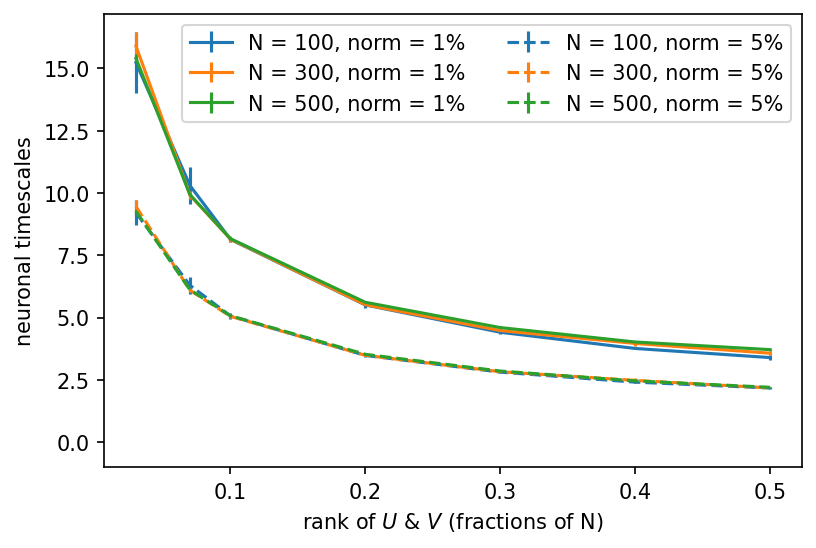

In [16]:
kids = []
for i, _t_d in enumerate(t_d):
    _kids = []
    for f_idx, ls in enumerate(['solid', 'dashed']):
        times = []
        for n in range(len(n_fracs)):
            times.append(_t_d[n][f_idx].numpy().squeeze())
        times = np.stack(times)
        _kids.append(plt.errorbar(n_fracs, times.mean(axis=1) / tau, times.std(axis=1) / tau, color=colors[i], linestyle=ls))
    kids.append(_kids)
plt.legend([_kids[0] for _kids in kids] + [_kids[1] for _kids in kids], [f'N = {N}, norm = {f[0] * 100:.0f}%' for N in Ns] + [f'N = {N}, norm = {f[1] * 100:.0f}%' for N in Ns], ncol=2)
plt.xlabel('rank of $U$ & $V$ (fractions of N)')
plt.ylabel('neuronal timescales')
plt.ylim(bottom=-1)
plt.show()

### Norm of activity vector $x(t)$ as a function of time
When plotting for each $N$ separately, show the mean and std across the repeats for each rank of $U$ and $V$. When plotting all the data together (lower right), show means only.

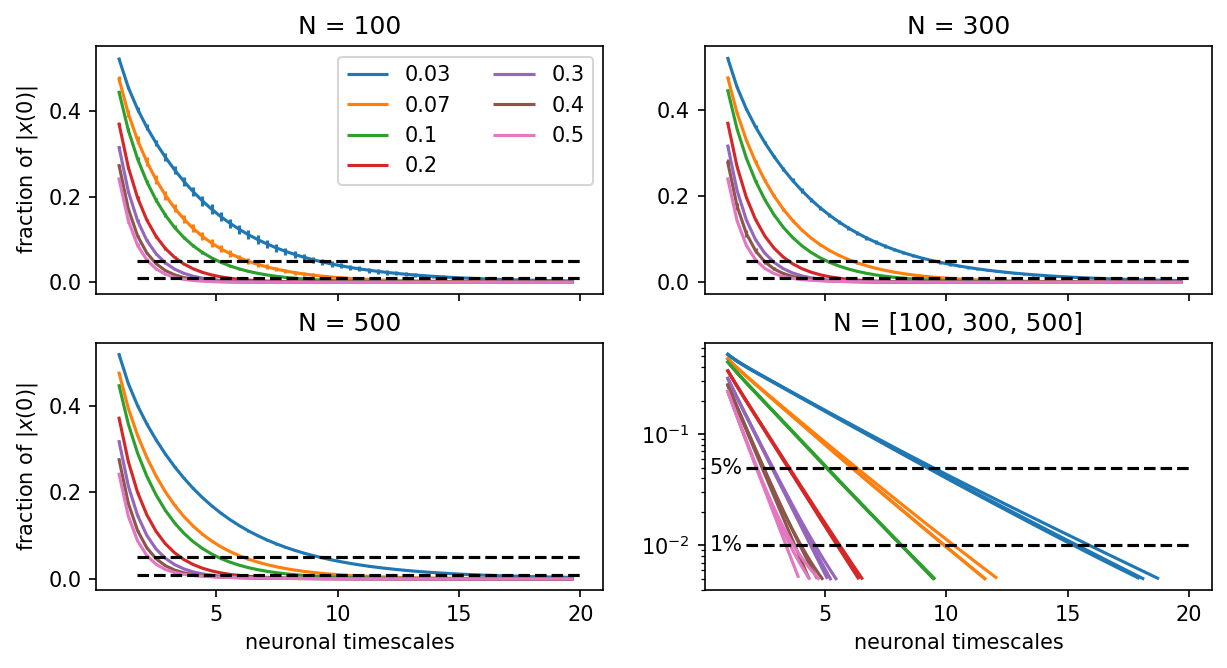

In [17]:
assert len(Ns) == 3, 'Formatting for this figure assumes len(Ns) == 3'
fig, axes = plt.subplots(2, 2, figsize=[4.8 * 2, 2.4 * 2], sharex=True)
axes = axes.flatten()
for i, (N, _norms, _t_d, ax, a) in enumerate(zip(Ns, norms, t_d, axes[:3], [1, .6, .2])):
    for n, norm in enumerate(_norms):
        ax.errorbar(t[::10], norm.mean(axis=0).flatten()[::10], norm.std(axis=0).flatten()[::10], color=colors[n])
        idx = t < _t_d[n][-1].numpy().mean(axis=0).flatten() / tau
        axes[3].plot(t[idx], norm.mean(axis=0).flatten()[idx], color=colors[n])
    ax.set_title(f'N = {N}')
for ax in axes:
    for _f in f[:2]:
        ax.plot([1.75, t.max()], [_f, _f], '--k', zorder=10)
axes[3].text(0.25, f[0], f'{f[0] * 100:.0f}%', verticalalignment='center')
axes[3].text(0.25, f[1], f'{f[1] * 100:.0f}%', verticalalignment='center')
axes[3].set_yscale('log')
# axes[3].set_ylim(top=2e0)
axes[3].set_title(f'N = {Ns}')
for ax in axes[::4]: ax.legend([ax.get_children()[n] for n in range(len(n_fracs))], [f'{n}' for n in n_fracs], ncol=2)
for ax in axes[2:]: ax.set_xlabel('neuronal timescales')
for ax in axes[::2]: ax.set_ylabel('fraction of $|x(0)|$')
plt.show()

# Statistics over $\beta$
We'll set $N=500$ and $\textrm{rank}(U)=0.1N$

### Model parameters

In [18]:
# network parameters
tau = 0.01  # neural time constant (s)
Ns = [200]  # network sizes, must be an iterable
n_fracs = [0.1]  # rank of U and V as fraction of N, must be an iterable
K = 5  # number of repeats per condition

# random seeds
numpy_seed = 1000

### Loss parameters

In [19]:
# penalty for solutions that don't decay
alpha = 1e5

# smoothness constraint
betas = [0, 0.01, 0.03, 0.1, 0.3, 0.9]  # for all the stats over N and n

### Learning parameters

In [20]:
# learning
adam_epochs = 30
adam_learning_rate = 0.01
lbfgs_iters = 1000
print_interval = 10
do_optimization = False
file_prefix = 'prep_opt_N_200'

In [21]:
# set numpy seed
npr.seed(numpy_seed)

### Learning
Same as before, but we save the optimized $U$'s and $V$'s in `prep_opt_for_beta_data.dill`.

In [22]:
if do_optimization:
    outs, models = [], []
    for b, beta in enumerate(betas):
        print(f'******************************************************')
        print(f'   beta = {beta}')
        print(f'******************************************************')
        print(os.popen(f'python train_models.py -T {tau} -N "{Ns[0]}" -F "{n_fracs[0]}" -k {K} -r {numpy_seed + b} -a {alpha} -b "{beta}" -A {adam_epochs} -l {adam_learning_rate} -L {lbfgs_iters} -p {print_interval} -f {file_prefix}_beta_{beta}.dill').read())

        with open(f'{file_prefix}_beta_{beta}.dill', 'rb') as f:
            out, model = dill.load(f)
        out, model = out[0], model[0]
        param, l_lbfgs, results = out
        out = dict(
            param=param,
            losses=np.stack(l_lbfgs),
            converged=results.converged,
            failed=results.failed
        )
        outs.append(out)
        models.append(model)
    with open(f'{file_prefix}_for_beta_data.dill', 'wb') as f:
        dill.dump((outs, models), f)    

Load saved $U$'s and $V$'s

In [23]:
with open(f'{file_prefix}_for_beta_data.dill', 'rb') as f:
    outs, models = dill.load(f)   

## Display results
For statistics over $N$ and the ranks of $U$ and $V$

Here, we plot:
* the learning curves
* the decay times as a function of $\beta$ for $N=500$ and $\textrm{rank}(U)=0.1N$
* the fractions $\|x(t)\|/\|x(0)\|$ as functions of the preparatory time $t$ for each $\beta$

### Display parameters

In [24]:
fracs = [0.01, 0.05]  # the fractions of the norms of the activity for which we want the decay times
t_min = 1  # min time when plotting decays (in units of tau)
t_max = 20  # max time when plotting decays (in units of tau)
loss_range = [0.6, 0.9]  # y-range when plotting second row of learning curves figure

### The learning curves

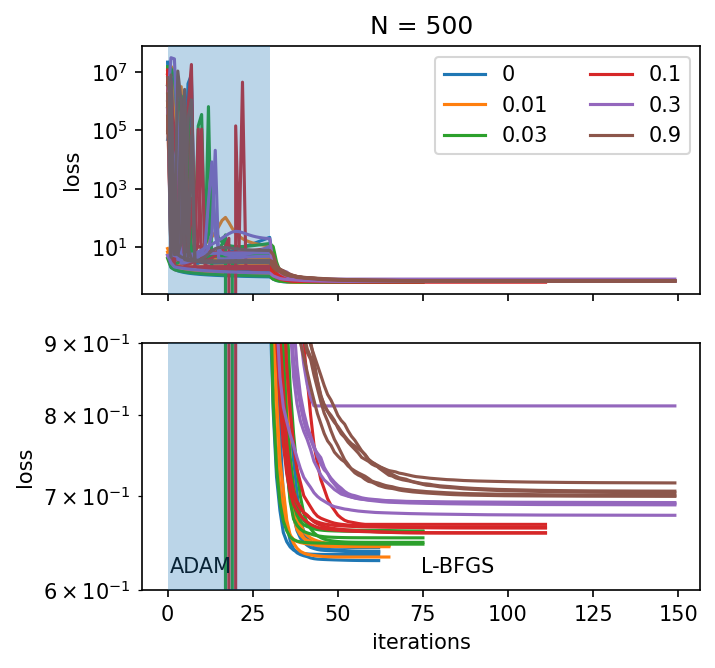

In [25]:
fig, axes = plt.subplots(2, len(Ns), figsize=[4.8 * len(Ns), 2.4 * 2], sharex=True, sharey='row')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for a, ax in enumerate(axes):
    for b, out in enumerate(outs):
        losses = out['losses']
        ax.plot(np.arange(min(losses.shape[0], 150)), losses[:150, ..., 0, 0], color=colors[b])

    ax.set_yscale('log')
    if a == 0:
        ax.set_title(f'N = {N}')
    else:
        ax.set_ylim(loss_range)
        ax.set_xlabel('iterations')
    rect = patches.Rectangle([0, .2], adam_epochs, 1e8, color=colors[0], alpha=0.3, ec=None, zorder=10)
    ax.add_patch(rect)
    ax.set_ylabel('loss')
    
axes[0].legend([axes[0].get_children()[K * b + 1] for b in range(len(betas))], [f'{beta}' for beta in betas], ncol=2)
axes[1].text(0.05, 0.07, f'ADAM', transform=axes[1].transAxes)
axes[1].text(0.5, 0.07, f'L-BFGS', transform=axes[1].transAxes)
plt.show()

### Compute decay times for each $\beta$

Find the decay times $t_d$ such that $f_\beta(t_d)$ equals the desired norm fractions in `fracs`

In [26]:
f = [*fracs, min(fracs) / 2]

print(f'Locating decay times for the norm fractions {f[:-1]}')
t_d = []
for beta, out, model in zip(betas, outs, models):
    print(f'   beta {beta}')
    norm_frac = get_norm_frac_fn(out['param'], model)

    _f = tf.stack([tf.ones(model['batch_shape'], dtype=tf.float64) * _f for _f in f])
    start = tf.ones([len(f), *model['batch_shape'], 1], dtype='float64') * 10 * model['tau']
    optim_results = tfp.optimizer.bfgs_minimize(
        lambda t: tfp.math.value_and_gradient(
            lambda t: (norm_frac(t) - _f)**2,
            t),
        initial_position=start,
        tolerance=1e-8)
#     assert not np.any(optim_results.failed), f'We failed. beta: {beta}'
#     assert np.all(optim_results.converged), f"We didn't converge. beta: {beta}"
#     assert np.allclose(_f, norm_frac(optim_results.position))
    t_d.append(optim_results.position)

Locating decay times for the norm fractions [0.01, 0.05]
   beta 0
   beta 0.01
   beta 0.03
   beta 0.1
   beta 0.3
   beta 0.9


Compute $f_\beta(t)$ for a range of $t$ as specified with `t_min` and `t_max`

In [27]:
t = np.linspace(t_min, t_max, 500)

print(f'Computing the norm fractions as a function of time')
norms = []
for beta, out, model in zip(betas, outs, models):
    print(f'   beta {beta}')
    norm_frac = get_norm_frac_fn(out['param'], model)
    _t = (t * tau).reshape(-1, *[1 for _ in model['batch_shape']], 1)
    norms.append(norm_frac(_t).numpy().squeeze().T)
norms = np.stack(norms)

Computing the norm fractions as a function of time
   beta 0
   beta 0.01
   beta 0.03
   beta 0.1
   beta 0.3
   beta 0.9


### Decay time as a function of the rank of $U$ and $V$
Each line is the mean $\pm1$ standard deviation over $K$ random samples of the matrices $J_0$ and the pre-optimized $U$ \& $V$

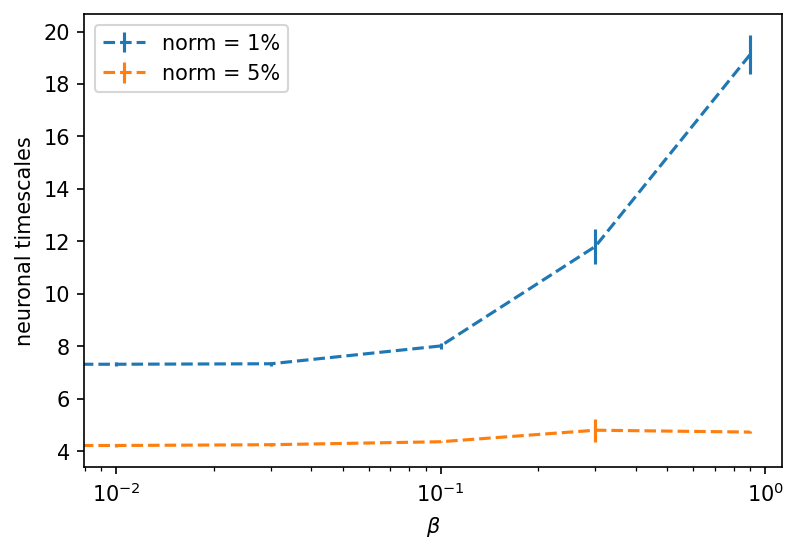

In [28]:
for f_idx, times in enumerate(np.swapaxes(np.stack(t_d).squeeze(), 0, 1)[:2]):
    plt.errorbar(betas, times.mean(axis=1) / tau, times.std(axis=1) / tau, linestyle=ls)
plt.legend([f'norm = {_f * 100:.0f}%' for _f in f[:-1]])
plt.xlabel('$\\beta$')
plt.xscale('log')
plt.ylabel('neuronal timescales')
# plt.ylim(bottom=-1)
plt.show()

### Norm of activity vector $x(t)$ as a function of time
When plotting for each $N$ separately, show the mean and std across the repeats for each rank of $U$ and $V$. When plotting all the data together (lower right), show means only.
The mean and std across the repeats for each $\beta$ on the left. Means only on the right.

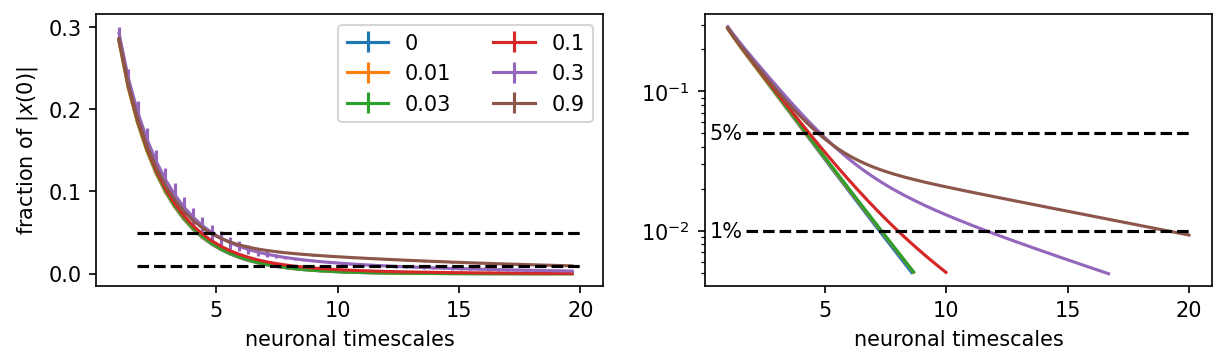

In [29]:
fig, axes = plt.subplots(1, 2, figsize=[4.8 * 2, 2.4 * 1], sharex=True)

for b, (beta, norm, _t_d) in enumerate(zip(betas, norms, t_d)):
    axes[0].errorbar(t[::10], norm.mean(axis=0).flatten()[::10], norm.std(axis=0).flatten()[::10], color=colors[b])
    idx = t < _t_d[-1].numpy().mean(axis=0).flatten() / tau
    axes[1].plot(t[idx], norm.mean(axis=0).flatten()[idx], color=colors[b])
axes[0].legend([f'{beta}' for beta in betas], ncol=2)
for ax in axes:
    for _f in f[:2]:
        ax.plot([1.75, t.max()], [_f, _f], '--k', zorder=10)
axes[1].text(0.25, f[0], f'{f[0] * 100:.0f}%', verticalalignment='center')
axes[1].text(0.25, f[1], f'{f[1] * 100:.0f}%', verticalalignment='center')
axes[1].set_yscale('log')
# axes[3].set_ylim(top=2e0)
# axes[3].set_title(f'N = {Ns}')
for ax in axes: ax.set_xlabel('neuronal timescales')
axes[0].set_ylabel('fraction of $|x(0)|$')
plt.show()